# Imports

In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime, timedelta
import geopandas
import matplotlib.pyplot as plt
import matplotlib.cm
import mapclassify
import matplotlib.patches as mpatches
import celluloid #pip install celluloid
from IPython.display import HTML # to display video in notebook (requires conda install ffmpeg)

# Add the path to tools folder, which contains plotting.py
import sys
sys.path.insert(0, "../tools")

from plotting import add_scalebar, add_north_arrow

# Prepare community shapes

Origin shapefile:

https://ac.ngi.be/remoteclient-open/ngi-standard-open/Vectordata/AdminVector/AdminVector_L08_shp.zip


In [2]:
communities_geom = geopandas.read_file('../data/NGI_AdminVector_L08_shp/AD_2_Municipality.shp')
NGI_url = 'zip+https://ac.ngi.be/remoteclient-open/ngi-standard-open/Vectordata/AdminVector/AdminVector_L08_shp.zip'
communities_geom.NISCode = communities_geom.NISCode.astype(int)
communities_geom = communities_geom[['NISCode','geometry']]

In [3]:
# read nb of inhabitants per municipality
url_inhabitants = 'https://statbel.fgov.be/sites/default/files/files/documents/bevolking/5.1%20Structuur%20van%20de%20bevolking/Bevolking_per_gemeente.xlsx'
inhabitants = pd.read_excel(url_inhabitants, skipfooter=4, skiprows=1).dropna(how='all', axis=0)
inhabitants['NIS code'] = inhabitants['NIS code'].astype(int)

In [ ]:
## Uncomment to save locally:
#inhabitants.to_csv('../data/inhabitants.csv')
## Uncomment to read locally:
#inhabitants = pd.read_csv('../data/inhabitants.csv')

In [4]:
# Add inhabitants info to communities shapes
communities = pd.merge(communities_geom, inhabitants, left_on = 'NISCode', right_on = 'NIS code').drop(columns=['NIS code'])
communities = communities.rename(columns={'Totaal':'inhabitants'})

In [ ]:
#communities.plot('inhabitants')

# Read sciensano data

In [5]:
## Get data until yesterday
datelist = pd.date_range(start = pd.to_datetime('2020-03-31'), end = datetime.today() - timedelta(days=1)).strftime("%Y%m%d")
#datelist = pd.date_range(start = pd.to_datetime('2020-03-31'), end = pd.to_datetime('2020-05-11')).strftime("%Y%m%d")

In [6]:
# To repeat the last frame a few times
datelist = list(datelist) + [datelist[-1]]*20

In [ ]:
# # Safe data locally (to be safe)
# for date in datelist:
#     url = 'https://epistat.sciensano.be/Data/'+ date +'/COVID19BE_CASES_MUNI_CUM_'+ date +'.csv'
#     cases_day_x = pd.read_csv(url, encoding = "ISO-8859-1", skipfooter=1).dropna(axis=0, how='all').copy()
#     cases_day_x.to_csv('../data/cumulative_cases_per_community/'+'COVID19BE_CASES_MUNI_CUM_'+ date +'.csv')

In [7]:
def prepare_case_data(date, read_local = False):
    if read_local == True:
        cases_day_x = pd.read_csv('../data/cumulative_cases_per_community/'+'COVID19BE_CASES_MUNI_CUM_'+ date +'.csv')
    else:
        url = 'https://epistat.sciensano.be/Data/'+ date +'/COVID19BE_CASES_MUNI_CUM_'+ date +'.csv'
        cases_day_x = pd.read_csv(url, encoding = "ISO-8859-1", skipfooter=1, engine='python').dropna(axis=0, how='all').copy()
        # engine = 'python' to avoid skipfooter warning
    cases_day_x.NIS5 = cases_day_x.NIS5.astype(int)
    cases_day_x = cases_day_x[['NIS5','TX_DESCR_NL','CASES']].copy()
    # Assume <5 cases to be 3 cases
    cases_day_x.loc[cases_day_x.CASES.str.find('<')!=-1, 'CASES'] = '3'
    cases_day_x.CASES = cases_day_x.CASES.astype(int)
    return cases_day_x

In [8]:
def prepare_plot_data(date, read_local = False):
    cases_day_x = prepare_case_data(date, read_local)
    cases_with_geo = pd.merge(communities[['NISCode', 'geometry', 'inhabitants']] , cases_day_x[['NIS5','CASES']], left_on = 'NISCode', right_on = 'NIS5')
    cases_with_geo['cases_per_100000'] = cases_with_geo.CASES/cases_with_geo.inhabitants*100000
    return cases_with_geo

# Make map

Origin Ugent logo: 

https://styleguide.ugent.be/files/uploads/logo_UGent_EN.zip

In [11]:
logo_ugent = plt.imread('../figures/logo_UGent_small.png')
# plt.imshow(logo_ugent)
# fig, ax = plt.subplots()
# fig.figimage(logo_ugent)

We use the **fisher_jenks scheme** for the legend. This scheme seeks to reduce the variance within classes and maximize the variance between classes. This is done by seeking to minimize each class's average deviation from the class mean, while maximizing each class's deviation from the means of the other groups. We prepare the legend for one of the last days, to take into account the largest number of cases.

http://darribas.org/gds15/content/labs/lab_04.html

In [12]:
last = prepare_plot_data(datelist[-2])
classi = mapclassify.FisherJenks(last['cases_per_100000'], k=7)
FJ_bins = classi.bins.round(-1).astype(int)
FJ_bins = [0]+list(FJ_bins) # lower bound of the legend
FJ_bins[-1] = 100000 # upper bound of the legend

In [ ]:
# Check boundaries
#pd.cut(last['cases_per_100000'], bins= FJ_bins).value_counts()

In [13]:
# Prepare legend labels
lower_lims = [str(x) for x in FJ_bins[:-1]]
lower_lims[-1] = '> '+lower_lims[-1]
upper_lims = [' - ' + str(x) for x in FJ_bins[1:]]
upper_lims[-1] = ''
labels = [x+y for x,y in zip(lower_lims, upper_lims)]

# create 7 color patches in shades of orange
cmap = matplotlib.cm.get_cmap('Oranges')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=6)
patches = [mpatches.Patch(color=cmap(norm(i))) for i in range(7)]

In [14]:
# union of belgium (to draw contours)
Belgium = last.unary_union

In [15]:
def cleaned_plot(date, ax, read_local=False):
    temp = prepare_plot_data(date, read_local)
    temp.plot(column=pd.cut(temp['cases_per_100000'], bins= FJ_bins), cmap='Oranges', 
              legend=False, ax=ax, vmin=-1, vmax=6)
    ax.legend(patches, labels, loc = (0, 0.15), frameon=False, bbox_transform=ax.transAxes, title='# infected / 100000')

    geopandas.GeoSeries([Belgium.boundary]).plot(ax=ax, color='k', lw=0.1)

    add_north_arrow(ax, (0.9, 0.1))
    add_scalebar(ax, (512000, 530000), length=50000, fac=' 50 km')
    
    ax.text(0, 1.01, 'Cumulative cases per municipality on ' + pd.to_datetime(date).strftime('%d %B %Y'), 
            transform=ax.transAxes, fontsize=12)
    
    ax.text(0, 0, 'Data sources: Sciensano, NGI-IGN Belgium, Statbel',
            transform=ax.transAxes, fontsize=10)
    ax.axis('off')
    newax = fig.add_axes([0.75, 0.75, 0.2, 0.2], anchor='NE', zorder=1)
    newax.imshow(logo_ugent, interpolation = 'spline16')
    newax.axis('off')
    ax.get_figure().tight_layout()
    
    return ax

In [ ]:
# Test plot
# fig, ax = plt.subplots(figsize=(8,8))

# cleaned_plot(datelist[10], ax, read_local=True)

In [16]:
# to ignore tight_layout warning
import warnings
warnings.filterwarnings("ignore")

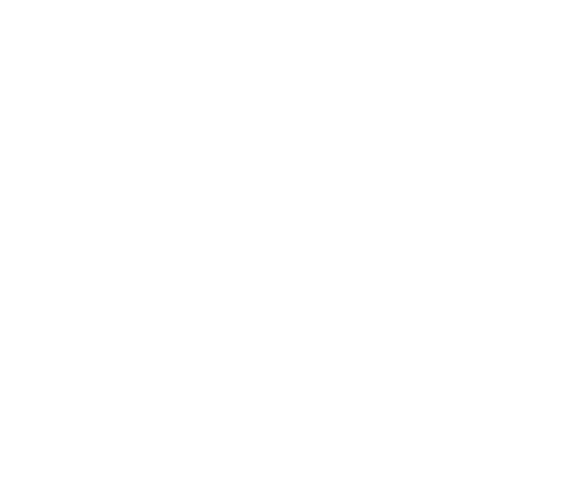

In [17]:
# takes long! about 2s per frame
fig, ax = plt.subplots(figsize=(8,8))
camera = celluloid.Camera(fig)
ax = cleaned_plot(datelist[0], ax)
camera.snap()
for date in datelist[1:]: # 1:...
    cleaned_plot(date, ax)
    camera.snap()
fig.tight_layout()
animation = camera.animate(interval=250)
HTML(animation.to_html5_video())

In [18]:
animation.save("../results/map_cases_dynamic.gif", writer='imagemagick')#, savefig_kwargs=dict(bbox='tight'))